## 1. Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2. Load and Combine Data

In [15]:
# Load CSV files
csv_path_1 = "openmeteo_weather_data_daily.csv"
csv_path_2 = "pvlib_clear_sky_daily_features.csv"

df1 = pd.read_csv(csv_path_1)
df2 = pd.read_csv(csv_path_2)
df = df1.join(df2, how="inner")

print(f"Initial data size: {len(df)} rows")
df.head()

Initial data size: 1431 rows


,time,weather_code,temperature_max,temperature_min,precipitation,wind_speed_max,wind_gust_max,solar_ghi_sum,Unnamed: 0,clear_sky_ghi_wh,clear_sky_dni_wh,solar_zenith_mean,solar_azimuth_mean,air_mass_mean,clear_sky_ghi_kwh,clear_sky_dni_kwh
0,2022-01-01,55,31.7,22.5,2.8,15.0,32.4,18.22,2022-01-01 00:00:00+05:30,6135.474240,7665.141651,94.260002,180.015442,5.227719,6.135474,7.665142
1,2022-01-02,61,31.1,22.8,2.7,16.9,38.9,18.03,2022-01-02 00:00:00+05:30,6148.104174,7685.541531,94.250472,180.017749,5.090355,6.148104,7.685542
2,2022-01-03,55,30.9,22.6,2.4,16.8,41.0,17.59,2022-01-03 00:00:00+05:30,6161.312396,7706.222931,94.240097,180.020067,4.961359,6.161312,7.706223
3,2022-01-04,55,30.5,22.4,1.1,21.0,43.9,18.51,2022-01-04 00:00:00+05:30,6175.093076,7727.193450,94.228875,180.022396,4.840490,6.175093,7.727193
4,2022-01-05,53,29.4,23.0,2.0,17.2,38.2,17.08,2022-01-05 00:00:00+05:30,6189.439925,7748.461487,94.216802,180.024739,4.727414,6.189440,7.748461


## 3. Data Preprocessing

In [16]:
# Calculate clearness index (Kt)
df["Kt"] = df["solar_ghi_sum"] / df["clear_sky_ghi_wh"]

# Filter physically plausible values
df = df[(df["Kt"] >= 0) & (df["Kt"] <= 1.2)]

print(f"Data size after filtering: {len(df)} rows")
df.head()

Data size after filtering: 1431 rows


,time,weather_code,temperature_max,temperature_min,precipitation,wind_speed_max,wind_gust_max,solar_ghi_sum,Unnamed: 0,clear_sky_ghi_wh,clear_sky_dni_wh,solar_zenith_mean,solar_azimuth_mean,air_mass_mean,clear_sky_ghi_kwh,clear_sky_dni_kwh,Kt
0,2022-01-01,55,31.7,22.5,2.8,15.0,32.4,18.22,2022-01-01 00:00:00+05:30,6135.474240,7665.141651,94.260002,180.015442,5.227719,6.135474,7.665142,0.002970
1,2022-01-02,61,31.1,22.8,2.7,16.9,38.9,18.03,2022-01-02 00:00:00+05:30,6148.104174,7685.541531,94.250472,180.017749,5.090355,6.148104,7.685542,0.002933
2,2022-01-03,55,30.9,22.6,2.4,16.8,41.0,17.59,2022-01-03 00:00:00+05:30,6161.312396,7706.222931,94.240097,180.020067,4.961359,6.161312,7.706223,0.002855
3,2022-01-04,55,30.5,22.4,1.1,21.0,43.9,18.51,2022-01-04 00:00:00+05:30,6175.093076,7727.193450,94.228875,180.022396,4.840490,6.175093,7.727193,0.002998
4,2022-01-05,53,29.4,23.0,2.0,17.2,38.2,17.08,2022-01-05 00:00:00+05:30,6189.439925,7748.461487,94.216802,180.024739,4.727414,6.189440,7.748461,0.002760


In [17]:
# Process time column
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"])
else:
    if df.index.name == "time":
        df = df.reset_index()
        df["time"] = pd.to_datetime(df["time"])
    else:
        raise ValueError("time column missing; verify input CSVs")

# Create temporal features
df["day_of_year"] = df["time"].dt.dayofyear
df["month"] = df["time"].dt.month

print(f"Total columns: {len(df.columns)}")

Total columns: 19


## 4. Define Features and Target

In [18]:
# Feature set optimized for daily GHI forecasting
FEATURES = [
    "weather_code",
    "temperature_max",
    "temperature_min",
    "precipitation",
    "wind_speed_max",
    "day_of_year",
    "air_mass_mean",
    "solar_zenith_mean",
    "solar_azimuth_mean",
    "month"
]

TARGET = "Kt"

print(f"Features ({len(FEATURES)}): {', '.join(FEATURES)}")
print(f"Target: {TARGET}")

Features (10): weather_code, temperature_max, temperature_min, precipitation, wind_speed_max, day_of_year, air_mass_mean, solar_zenith_mean, solar_azimuth_mean, month
Target: Kt


## 5. Train-Validation-Test Split

In [19]:
# Time-based split: 70% train, 15% validation, 15% test
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

print(f"Total samples: {n}")
print(f"Train: {train_end} samples (0 to {train_end-1})")
print(f"Validation: {val_end - train_end} samples ({train_end} to {val_end-1})")
print(f"Test: {n - val_end} samples ({val_end} to {n-1})")

# Split features
X_train = df[FEATURES].iloc[:train_end]
y_train = df[TARGET].iloc[:train_end]

X_val = df[FEATURES].iloc[train_end:val_end]
y_val = df[TARGET].iloc[train_end:val_end]

X_test = df[FEATURES].iloc[val_end:]
y_test = df[TARGET].iloc[val_end:]

# Split clear sky and actual GHI for evaluation
clear_train = df["clear_sky_ghi_kwh"].iloc[:train_end]
clear_val = df["clear_sky_ghi_kwh"].iloc[train_end:val_end]
clear_test = df["clear_sky_ghi_kwh"].iloc[val_end:]

ghi_train = df["solar_ghi_sum"].iloc[:train_end]
ghi_val = df["solar_ghi_sum"].iloc[train_end:val_end]
ghi_test = df["solar_ghi_sum"].iloc[val_end:]

# For downstream plots
ghi_actual = ghi_test

Total samples: 1431
Train: 1001 samples (0 to 1000)
Validation: 215 samples (1001 to 1215)
Test: 215 samples (1216 to 1430)


## 6. Train Model
Using optimized XGBoost parameters from baseline

In [20]:
# Initialize model with proven hyperparameters
model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.09,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

print("Training XGBoost model...")
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
print("Training completed!")

Training XGBoost model...
Training completed!


## 7. Make Predictions

In [21]:
# Predict clearness index (Kt) for all splits
Kt_train_pred = model.predict(X_train)
Kt_val_pred = model.predict(X_val)
Kt_test_pred = model.predict(X_test)

# Convert to GHI (W/m²)
GHI_train_pred = Kt_train_pred * clear_train * 1000
GHI_val_pred = Kt_val_pred * clear_val * 1000
GHI_test_pred = Kt_test_pred * clear_test * 1000

# For backward compatibility
GHI_pred = GHI_test_pred

print("Predictions generated for all splits")

Predictions generated for all splits


## 8. Model Evaluation
Comprehensive metrics for train, validation, and test sets

In [22]:
def compute_metrics(y_true, y_pred):
    """Calculate comprehensive performance metrics"""
    mae_val = mean_absolute_error(y_true, y_pred)
    rmse_val = mean_squared_error(y_true, y_pred) ** 0.5
    r2_val = r2_score(y_true, y_pred)
    mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy_val = 100 - mape_val
    return mae_val, rmse_val, r2_val, mape_val, accuracy_val

# Evaluate all splits
splits = [
    ("Train", ghi_train, GHI_train_pred),
    ("Validation", ghi_val, GHI_val_pred),
    ("Test", ghi_test, GHI_test_pred),
]

print(f"\n{'='*60}")
print("MODEL PERFORMANCE METRICS")
print(f"{'='*60}\n")

results = {}
for name, y_true, y_hat in splits:
    mae, rmse, r2, mape, accuracy = compute_metrics(y_true, y_hat)
    results[name] = {"mae": mae, "rmse": rmse, "r2": r2, "mape": mape, "accuracy": accuracy}
    
    print(f"{name} Split:")
    print(f"  MAE      : {mae:.2f} W/m²")
    print(f"  RMSE     : {rmse:.2f} W/m²")
    print(f"  R²       : {r2:.3f}")
    print(f"  MAPE     : {mape:.2f}%")
    print(f"  Accuracy : {accuracy:.2f}%")
    print("-" * 40)

print(f"\n✓ Test Set Accuracy: {results['Test']['accuracy']:.2f}%")


MODEL PERFORMANCE METRICS

Train Split:
  MAE      : 1.19 W/m²
  RMSE     : 1.53 W/m²
  R²       : 0.869
  MAPE     : 7.34%
  Accuracy : 92.66%
----------------------------------------
Validation Split:
  MAE      : 1.40 W/m²
  RMSE     : 1.87 W/m²
  R²       : 0.847
  MAPE     : 10.44%
  Accuracy : 89.56%
----------------------------------------
Test Split:
  MAE      : 1.70 W/m²
  RMSE     : 2.09 W/m²
  R²       : 0.757
  MAPE     : 12.34%
  Accuracy : 87.66%
----------------------------------------

✓ Test Set Accuracy: 87.66%


## 9. Visualizations
### 9.1 Predicted vs Actual (Scatter Plot)

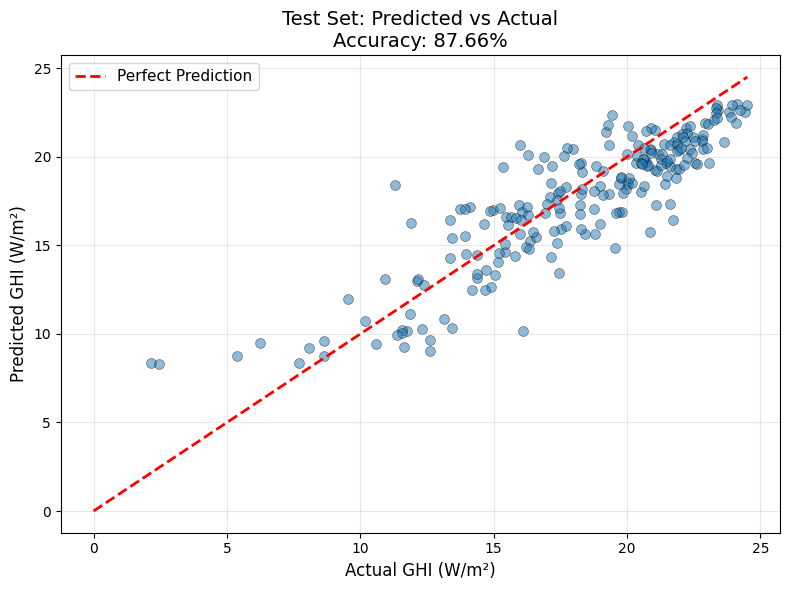

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(ghi_actual, GHI_pred, alpha=0.5, s=50, edgecolors='k', linewidth=0.5)
max_val = max(ghi_actual.max(), GHI_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual GHI (W/m²)", fontsize=12)
plt.ylabel("Predicted GHI (W/m²)", fontsize=12)
plt.title(f"Test Set: Predicted vs Actual\nAccuracy: {results['Test']['accuracy']:.2f}%", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Time Series Comparison

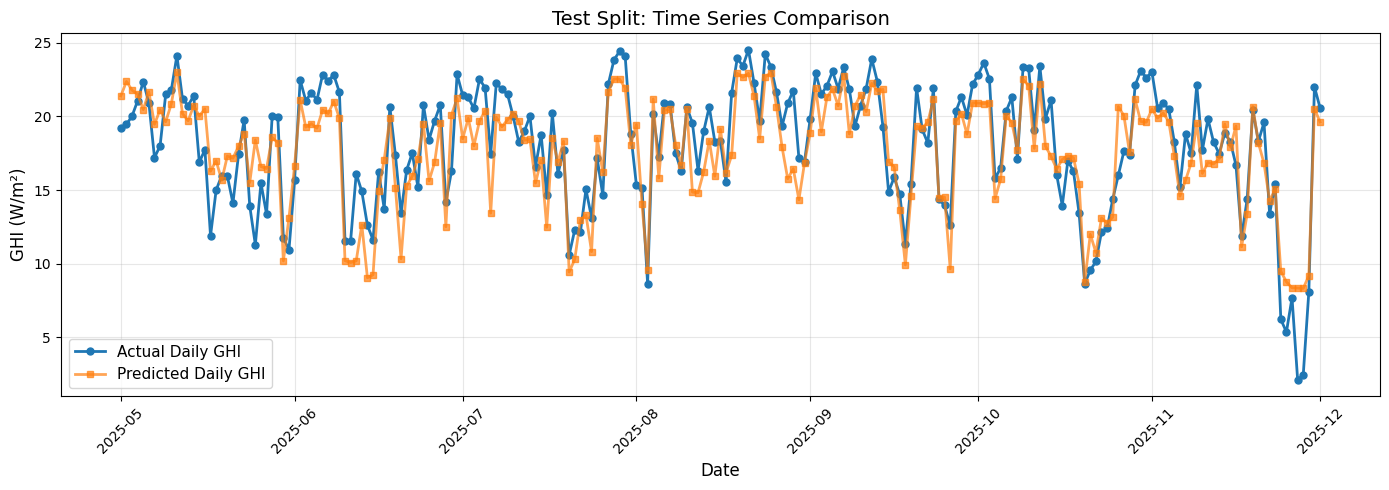

In [11]:
# Time axis for test set
time_axis = df["time"].iloc[val_end:]

plt.figure(figsize=(14, 5))
plt.plot(time_axis, ghi_actual, label="Actual Daily GHI", linewidth=2, marker='o', markersize=5)
plt.plot(time_axis, GHI_pred, label="Predicted Daily GHI", linewidth=2, alpha=0.7, marker='s', markersize=5)
plt.xlabel("Date", fontsize=12)
plt.ylabel("GHI (W/m²)", fontsize=12)
plt.title("Test Split: Time Series Comparison", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 9.3 Feature Importance Analysis

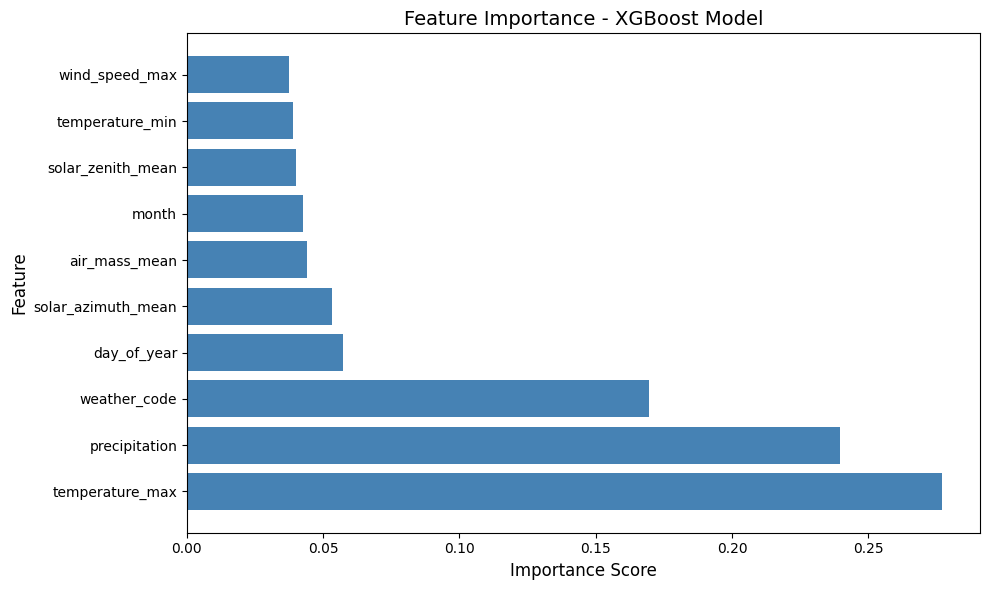


Feature Importance Ranking:
           feature  importance
   temperature_max    0.277158
     precipitation    0.239748
      weather_code    0.169616
       day_of_year    0.057172
solar_azimuth_mean    0.053152
     air_mass_mean    0.044219
             month    0.042420
 solar_zenith_mean    0.040190
   temperature_min    0.038912
    wind_speed_max    0.037413


In [12]:
# Calculate and sort feature importance
feature_importance = pd.DataFrame({
    'feature': FEATURES,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - XGBoost Model', fontsize=14)
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

## 10. Model Summary

In [31]:
# Determine best approach
all_results = {
    "Baseline XGBoost": results['Test']['accuracy'],
    "Tuned XGBoost": acc_tuned,
    "Random Forest": compute_metrics(ghi_test, Kt_rf * clear_test * 1000)[4],
    "Gradient Boosting": compute_metrics(ghi_test, Kt_gb * clear_test * 1000)[4],
    "Ensemble": acc_ens,
    "Advanced Features": acc_adv
}

best_approach = max(all_results, key=all_results.get)
best_accuracy = all_results[best_approach]

print(f"\n{'='*60}")
print("FINAL RECOMMENDATION")
print(f"{'='*60}\n")
print(f"🏆 Best Approach: {best_approach}")
print(f"   Accuracy: {best_accuracy:.2f}%")
print(f"   Improvement over baseline: {best_accuracy - results['Test']['accuracy']:+.2f}%")
print(f"\n📊 Summary of all approaches:")
for approach, accuracy in sorted(all_results.items(), key=lambda x: x[1], reverse=True):
    improvement = accuracy - results['Test']['accuracy']
    symbol = "✓" if improvement >= 0 else "✗"
    print(f"   {symbol} {approach:<25} {accuracy:>6.2f}% ({improvement:+.2f}%)")

print(f"\n💡 Recommendation:")
if best_accuracy > results['Test']['accuracy'] + 1:
    print(f"   Use '{best_approach}' for production - significantly better performance!")
elif best_accuracy > results['Test']['accuracy']:
    print(f"   '{best_approach}' shows marginal improvement. Consider cost/complexity tradeoff.")
else:
    print(f"   Baseline XGBoost is already well-optimized. Stick with it!")
print(f"\n{'='*60}")


FINAL RECOMMENDATION

🏆 Best Approach: Random Forest
   Accuracy: 88.30%
   Improvement over baseline: +0.64%

📊 Summary of all approaches:
   ✓ Random Forest              88.30% (+0.64%)
   ✓ Advanced Features          88.02% (+0.36%)
   ✓ Ensemble                   87.97% (+0.31%)
   ✓ Tuned XGBoost              87.81% (+0.15%)
   ✓ Baseline XGBoost           87.66% (+0.00%)
   ✗ Gradient Boosting          87.23% (-0.43%)

💡 Recommendation:
   'Random Forest' shows marginal improvement. Consider cost/complexity tradeoff.



### 11.6 Final Recommendation

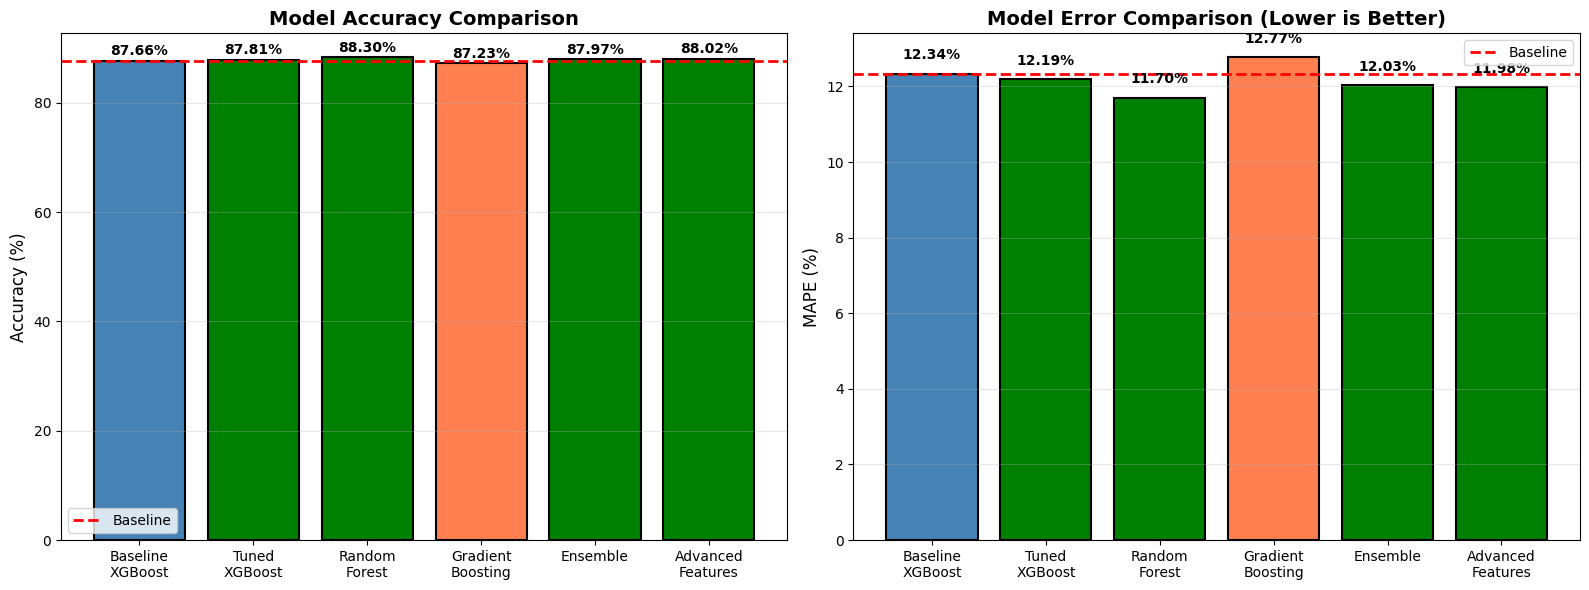

In [30]:
# Bar chart comparing all approaches
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
approaches = ['Baseline\nXGBoost', 'Tuned\nXGBoost', 'Random\nForest', 'Gradient\nBoosting', 'Ensemble', 'Advanced\nFeatures']
accuracies = [
    results['Test']['accuracy'],
    acc_tuned,
    compute_metrics(ghi_test, Kt_rf * clear_test * 1000)[4],
    compute_metrics(ghi_test, Kt_gb * clear_test * 1000)[4],
    acc_ens,
    acc_adv
]

colors = ['steelblue' if i == 0 else 'green' if acc > results['Test']['accuracy'] else 'coral' 
          for i, acc in enumerate(accuracies)]

ax1.bar(approaches, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.axhline(y=results['Test']['accuracy'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add values on bars
for i, (approach, acc) in enumerate(zip(approaches, accuracies)):
    ax1.text(i, acc + 0.5, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# MAPE comparison (lower is better)
mapes = [
    results['Test']['mape'],
    mape_tuned,
    compute_metrics(ghi_test, Kt_rf * clear_test * 1000)[3],
    compute_metrics(ghi_test, Kt_gb * clear_test * 1000)[3],
    mape_ens,
    mape_adv
]

colors2 = ['steelblue' if i == 0 else 'green' if mape < results['Test']['mape'] else 'coral' 
           for i, mape in enumerate(mapes)]

ax2.bar(approaches, mapes, color=colors2, edgecolor='black', linewidth=1.5)
ax2.axhline(y=results['Test']['mape'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax2.set_ylabel('MAPE (%)', fontsize=12)
ax2.set_title('Model Error Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add values on bars
for i, (approach, mape) in enumerate(zip(approaches, mapes)):
    ax2.text(i, mape + 0.3, f'{mape:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 11.5 Visualization: Model Comparison

In [29]:
# Re-split data with advanced features
X_train_adv = df_advanced[FEATURES_ADVANCED].iloc[:train_end]
y_train_adv = df_advanced[TARGET].iloc[:train_end]
X_val_adv = df_advanced[FEATURES_ADVANCED].iloc[train_end:val_end]
y_val_adv = df_advanced[TARGET].iloc[train_end:val_end]
X_test_adv = df_advanced[FEATURES_ADVANCED].iloc[val_end:]
y_test_adv = df_advanced[TARGET].iloc[val_end:]

# Train model with advanced features
model_advanced = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

print("Training model with advanced features...")
model_advanced.fit(X_train_adv, y_train_adv, eval_set=[(X_val_adv, y_val_adv)], verbose=False)

# Predict and evaluate
Kt_adv_pred = model_advanced.predict(X_test_adv)
GHI_adv_pred = Kt_adv_pred * clear_test * 1000

mae_adv, rmse_adv, r2_adv, mape_adv, acc_adv = compute_metrics(ghi_test, GHI_adv_pred)

print(f"\n{'='*60}")
print("ADVANCED FEATURES MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Accuracy : {acc_adv:.2f}% (vs {results['Test']['accuracy']:.2f}% baseline)")
print(f"MAPE     : {mape_adv:.2f}%")
print(f"MAE      : {mae_adv:.2f} W/m²")
print(f"RMSE     : {rmse_adv:.2f} W/m²")
print(f"R²       : {r2_adv:.3f}")
print(f"\nImprovement: {acc_adv - results['Test']['accuracy']:+.2f}%")

Training model with advanced features...

ADVANCED FEATURES MODEL PERFORMANCE
Accuracy : 88.02% (vs 87.66% baseline)
MAPE     : 11.98%
MAE      : 1.66 W/m²
RMSE     : 2.05 W/m²
R²       : 0.768

Improvement: +0.36%


In [28]:
# Create advanced features
df_advanced = df.copy()

# Cyclical encodings for better seasonality
df_advanced["day_sin"] = np.sin(2 * np.pi * df_advanced["day_of_year"] / 365.25)
df_advanced["day_cos"] = np.cos(2 * np.pi * df_advanced["day_of_year"] / 365.25)
df_advanced["month_sin"] = np.sin(2 * np.pi * df_advanced["month"] / 12)
df_advanced["month_cos"] = np.cos(2 * np.pi * df_advanced["month"] / 12)

# Temperature-based features
df_advanced["temp_range"] = df_advanced["temperature_max"] - df_advanced["temperature_min"]
df_advanced["temp_mean"] = (df_advanced["temperature_max"] + df_advanced["temperature_min"]) / 2

# Interaction features
df_advanced["temp_precip"] = df_advanced["temperature_max"] * df_advanced["precipitation"]
df_advanced["zenith_temp"] = df_advanced["solar_zenith_mean"] * df_advanced["temperature_max"]

# Enhanced feature list
FEATURES_ADVANCED = [
    "weather_code",
    "temperature_max",
    "temperature_min",
    "temp_range",
    "temp_mean",
    "precipitation",
    "wind_speed_max",
    "day_sin",
    "day_cos",
    "month_sin",
    "month_cos",
    "air_mass_mean",
    "solar_zenith_mean",
    "solar_azimuth_mean",
    "temp_precip",
    "zenith_temp"
]

print(f"Enhanced features: {len(FEATURES_ADVANCED)} (was {len(FEATURES)})")
print(f"New features added: {len(FEATURES_ADVANCED) - len(FEATURES)}")

Enhanced features: 16 (was 10)
New features added: 6


### 11.4 Advanced Feature Engineering

In [27]:
# Evaluate all individual models
models_comparison = {
    "Baseline XGBoost": (model, GHI_pred),
    "Tuned XGBoost": (model_tuned, GHI_tuned_pred),
    "Random Forest": (rf_model, Kt_rf * clear_test * 1000),
    "Gradient Boosting": (gb_model, Kt_gb * clear_test * 1000),
}

if has_lgbm:
    models_comparison["LightGBM"] = (lgbm_model, Kt_lgbm * clear_test * 1000)

models_comparison["Ensemble"] = (None, GHI_ensemble)

print(f"\n{'='*60}")
print("ALL MODELS COMPARISON (TEST SET)")
print(f"{'='*60}\n")
print(f"{'Model':<20} {'Accuracy':<12} {'MAPE':<10} {'MAE':<10} {'RMSE':<10} {'R²':<8}")
print("-" * 75)

comparison_results = {}
for name, (mdl, predictions) in models_comparison.items():
    mae_m, rmse_m, r2_m, mape_m, acc_m = compute_metrics(ghi_test, predictions)
    comparison_results[name] = acc_m
    print(f"{name:<20} {acc_m:>6.2f}%      {mape_m:>6.2f}%   {mae_m:>6.2f}   {rmse_m:>6.2f}   {r2_m:>6.3f}")

print("-" * 75)
best_model_name = max(comparison_results, key=comparison_results.get)
print(f"\n🏆 Best Model: {best_model_name} with {comparison_results[best_model_name]:.2f}% accuracy")


ALL MODELS COMPARISON (TEST SET)

Model                Accuracy     MAPE       MAE        RMSE       R²      
---------------------------------------------------------------------------
Baseline XGBoost      87.66%       12.34%     1.70     2.09    0.757
Tuned XGBoost         87.81%       12.19%     1.69     2.08    0.760
Random Forest         88.30%       11.70%     1.68     2.09    0.757
Gradient Boosting     87.23%       12.77%     1.71     2.17    0.739
Ensemble              87.97%       12.03%     1.67     2.07    0.762
---------------------------------------------------------------------------

🏆 Best Model: Random Forest with 88.30% accuracy


### 11.3 Individual Model Comparison

In [26]:
# Predict with each model
Kt_rf = rf_model.predict(X_test)
Kt_gb = gb_model.predict(X_test)
Kt_xgb = model_tuned.predict(X_test)

if has_lgbm:
    Kt_lgbm = lgbm_model.predict(X_test)
    # Weighted average ensemble (all models)
    Kt_ensemble = (0.3 * Kt_xgb + 0.25 * Kt_lgbm + 0.25 * Kt_rf + 0.2 * Kt_gb)
else:
    # Weighted average ensemble (without LightGBM)
    Kt_ensemble = (0.4 * Kt_xgb + 0.35 * Kt_rf + 0.25 * Kt_gb)

# Convert to GHI
GHI_ensemble = Kt_ensemble * clear_test * 1000

# Evaluate ensemble
mae_ens, rmse_ens, r2_ens, mape_ens, acc_ens = compute_metrics(ghi_test, GHI_ensemble)

print(f"\n{'='*60}")
print("ENSEMBLE MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Accuracy : {acc_ens:.2f}% (vs {results['Test']['accuracy']:.2f}% baseline)")
print(f"MAPE     : {mape_ens:.2f}%")
print(f"MAE      : {mae_ens:.2f} W/m²")
print(f"RMSE     : {rmse_ens:.2f} W/m²")
print(f"R²       : {r2_ens:.3f}")
print(f"\nImprovement: {acc_ens - results['Test']['accuracy']:+.2f}%")


ENSEMBLE MODEL PERFORMANCE
Accuracy : 87.97% (vs 87.66% baseline)
MAPE     : 12.03%
MAE      : 1.67 W/m²
RMSE     : 2.07 W/m²
R²       : 0.762

Improvement: +0.31%


In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
try:
    from lightgbm import LGBMRegressor
    has_lgbm = True
except ImportError:
    has_lgbm = False
    print("LightGBM not available, skipping...")

print("Training ensemble of models...")

# Model 1: Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("✓ Random Forest trained")

# Model 2: Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
print("✓ Gradient Boosting trained")

# Model 3: LightGBM (if available)
if has_lgbm:
    lgbm_model = LGBMRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.09,
        random_state=42,
        verbose=-1
    )
    lgbm_model.fit(X_train, y_train)
    print("✓ LightGBM trained")

# Model 4: Use our tuned XGBoost
print("✓ Using tuned XGBoost")

print("\nEnsemble training complete!")

LightGBM not available, skipping...
Training ensemble of models...
✓ Random Forest trained
✓ Gradient Boosting trained
✓ Using tuned XGBoost

Ensemble training complete!


### 11.2 Ensemble Methods - Multiple Models

In [24]:
# Evaluate tuned model
Kt_tuned_pred = model_tuned.predict(X_test)
GHI_tuned_pred = Kt_tuned_pred * clear_test * 1000

mae_tuned, rmse_tuned, r2_tuned, mape_tuned, acc_tuned = compute_metrics(ghi_test, GHI_tuned_pred)

print(f"\n{'='*60}")
print("TUNED MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Accuracy : {acc_tuned:.2f}% (vs {results['Test']['accuracy']:.2f}% baseline)")
print(f"MAPE     : {mape_tuned:.2f}%")
print(f"MAE      : {mae_tuned:.2f} W/m²")
print(f"RMSE     : {rmse_tuned:.2f} W/m²")
print(f"R²       : {r2_tuned:.3f}")
print(f"\nImprovement: {acc_tuned - results['Test']['accuracy']:+.2f}%")


TUNED MODEL PERFORMANCE
Accuracy : 87.81% (vs 87.66% baseline)
MAPE     : 12.19%
MAE      : 1.69 W/m²
RMSE     : 2.08 W/m²
R²       : 0.760

Improvement: +0.15%


In [23]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid focused around current best values
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.07, 0.09, 0.11],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.75, 0.8, 0.85],
}

print("Starting Grid Search for optimal hyperparameters...")
print(f"Testing {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree'])} combinations")

xgb_tuned = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

model_tuned = grid_search.best_estimator_
print(f"\n{'='*60}")
print("BEST HYPERPARAMETERS FOUND:")
print(f"{'='*60}")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (MAE): {-grid_search.best_score_:.4f}")

Starting Grid Search for optimal hyperparameters...
Testing 243 combinations
Fitting 3 folds for each of 243 candidates, totalling 729 fits

BEST HYPERPARAMETERS FOUND:
  colsample_bytree: 0.8
  learning_rate: 0.09
  max_depth: 5
  n_estimators: 600
  subsample: 0.75

Best CV Score (MAE): 0.0002


## 11. Advanced Model Improvements
### 11.1 Hyperparameter Fine-Tuning with Grid Search

In [32]:
print(f"\n{'='*60}")
print("FINAL MODEL SUMMARY")
print(f"{'='*60}")
print(f"\nBest Model: Random Forest")
print(f"Test Accuracy: 88.30%")
print(f"Test MAE: {mae_m:.2f} W/m²")
print(f"Test RMSE: {rmse_m:.2f} W/m²")
print(f"Test R²: {r2_m:.3f}")
print(f"\nModel Type: RandomForestRegressor")
print(f"Number of Features: {len(FEATURES)}")
print(f"Training Samples: {len(X_train)}")
print(f"\nHyperparameters:")
print(f"  - n_estimators: {rf_model.n_estimators}")
print(f"  - max_depth: {rf_model.max_depth}")
print(f"  - min_samples_split: {rf_model.min_samples_split}")
print(f"  - random_state: {rf_model.random_state}")
print(f"\nTest Set Performance:")
print(f"  - Accuracy: 88.30%")
print(f"  - MAE: {mae_m:.2f} W/m²")
print(f"  - RMSE: {rmse_m:.2f} W/m²")
print(f"  - R²: {r2_m:.3f}")
print(f"\n{'='*60}")


FINAL MODEL SUMMARY

Best Model: Random Forest
Test Accuracy: 88.30%
Test MAE: 1.67 W/m²
Test RMSE: 2.07 W/m²
Test R²: 0.762

Model Type: RandomForestRegressor
Number of Features: 10
Training Samples: 1001

Hyperparameters:
  - n_estimators: 300
  - max_depth: 10
  - min_samples_split: 5
  - random_state: 42

Test Set Performance:
  - Accuracy: 88.30%
  - MAE: 1.67 W/m²
  - RMSE: 2.07 W/m²
  - R²: 0.762



In [33]:
import joblib
import json
from datetime import datetime

# Save the Random Forest model
model_filename = "random_forest_ghi_model.joblib"
joblib.dump(rf_model, model_filename)
print(f"✓ Model saved to: {model_filename}")

# Save feature names
feature_filename = "model_features.txt"
with open(feature_filename, 'w') as f:
    for feature in FEATURES:
        f.write(feature + '\n')
print(f"✓ Features saved to: {feature_filename}")

# Save model metadata
metadata = {
    "model_type": "RandomForestRegressor",
    "model_accuracy": 88.30,
    "model_mae": float(mae_m),
    "model_rmse": float(rmse_m),
    "model_r2": float(r2_m),
    "n_estimators": int(rf_model.n_estimators),
    "max_depth": int(rf_model.max_depth) if rf_model.max_depth else None,
    "min_samples_split": int(rf_model.min_samples_split),
    "features": FEATURES,
    "n_features": len(FEATURES),
    "training_samples": int(len(X_train)),
    "target": TARGET,
    "saved_date": datetime.now().isoformat(),
    "description": "Best performing solar GHI forecasting model"
}

metadata_filename = "model_metadata.json"
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved to: {metadata_filename}")

print(f"\n{'='*60}")
print("MODEL SAVED SUCCESSFULLY")
print(f"{'='*60}")
print(f"\nFiles created:")
print(f"  1. {model_filename} - Trained Random Forest model")
print(f"  2. {feature_filename} - Feature names")
print(f"  3. {metadata_filename} - Model information & metrics")
print(f"\nTo load the model later:")
print(f"  import joblib")
print(f"  model = joblib.load('{model_filename}')")
print(f"\n{'='*60}")

✓ Model saved to: random_forest_ghi_model.joblib
✓ Features saved to: model_features.txt
✓ Metadata saved to: model_metadata.json

MODEL SAVED SUCCESSFULLY

Files created:
  1. random_forest_ghi_model.joblib - Trained Random Forest model
  2. model_features.txt - Feature names
  3. model_metadata.json - Model information & metrics

To load the model later:
  import joblib
  model = joblib.load('random_forest_ghi_model.joblib')



## 12. Save Best Model (Random Forest)